## NLP Class Final Project Read Data

In [ ]:
!pip install pyarrow
!pip install pandarallel
!pip install nltk
!!sudo /opt/conda/bin/python3 -m pip install ktrain

In [2]:
## Load data

import pandas as pd
import numpy as np
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 8.74 s, sys: 5.74 s, total: 14.5 s
Wall time: 15.6 s


(200332, 5)

In [4]:
df_news_final_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       200332 non-null  object
 1   date      200332 non-null  object
 2   language  200332 non-null  object
 3   title     200332 non-null  object
 4   text      200332 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


In [5]:
df_news_final_project.sample(5)

,url,date,language,title,text
40911,https://www.fedscoop.com/lawmakers-want-ai-tas...,2022-01-28,en,Lawmakers want task force designing national A...,\n\nLawmakers want task force designing nation...
64712,https://galusaustralis.com/2020/10/1029529/glo...,2020-10-23,en,Global Artificial Intelligence Robots Market B...,\n\nGlobal Artificial Intelligence Robots Mark...
56250,https://www.news18.com/amp/tech/open-ai-finall...,2023-03-19,en,Open AI Finally Lets Indians Pay For ChatGPT P...,Open AI Finally Lets Indians Pay For ChatGPT P...
8823,https://www.newsbreak.com/news/2924403424982-a...,2023-02-24,en,Artificial Intelligence Stocks Are Hot: Here A...,Artificial Intelligence Stocks Are Hot: Here A...
24129,https://www.taiwannews.com.tw/en/news/4845437,2023-03-24,en,Bitumen Additives Market Understanding the Imp...,\n\n Bitumen Additives Market Understanding th...


### EDA

* url : link to the news article
* date : date of publication
* language : language of the article
* title : article title
* text : article text

In [6]:
df_news_final_project.nunique()

url         200332
date          1213
language         1
title       140223
text        198564
dtype: int64

In [7]:
df_news_final_project['date'] = pd.to_datetime(df_news_final_project['date'])

print("Minimum Date:", df_news_final_project['date'].min())
print("Maximum Date:", df_news_final_project['date'].max())

Minimum Date: 2020-01-01 00:00:00
Maximum Date: 2023-04-28 00:00:00


In [8]:

lengths = [len(sentence) for sentence in df_news_final_project['text']]
print(min(sorted(lengths)))
print(max(sorted(lengths)))


18
580772


In [9]:
np.mean(lengths)

9037.717873330272

We can clearly observe the following :

* Multiple entries where different urls relay the same news. Only 198564 unique news articles.
* All the news articles are extracted from websites reporting news in English.
* News articles reported for 1213 days between Jan 1 2020 and Apr 28 2023.
* We have multiple different articles with the same news title.
* Average length of unclean articles in ~9k.

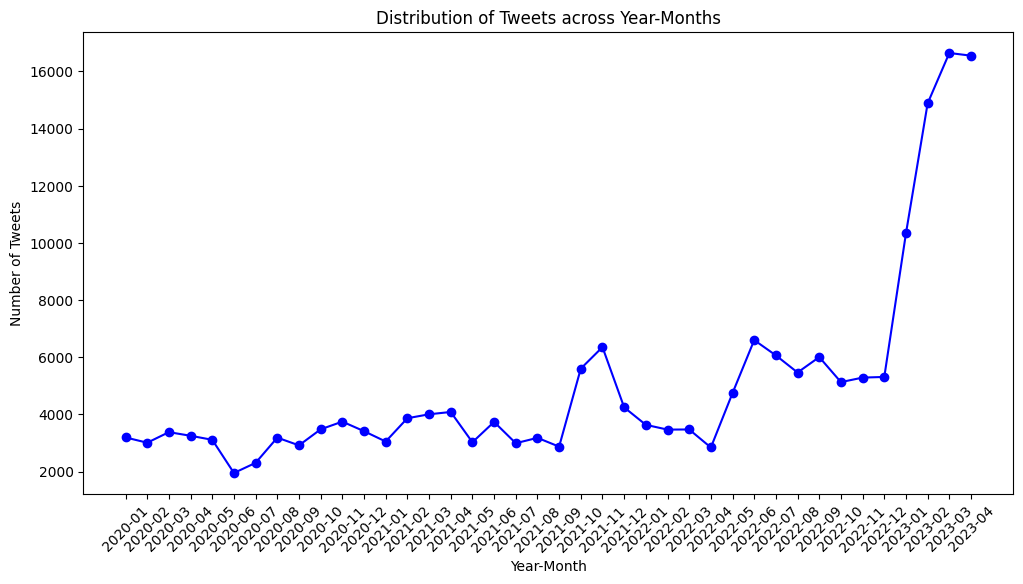

In [10]:
# Convert the 'date' column to datetime if it's not already in datetime format
df_news_final_project['date'] = pd.to_datetime(df_news_final_project['date'])

# Extract the year and month from the 'date' column
df_news_final_project['year_month'] = df_news_final_project['date'].dt.to_period('M')

# Group the data by year-month and count the number of tweets
tweet_counts = df_news_final_project.groupby('year_month').size()

# Convert the index to string representation
tweet_counts.index = tweet_counts.index.strftime('%Y-%m')

# Create a range of year-months for the x-axis tick labels
year_months = pd.period_range(start=min(df_news_final_project['year_month']), end=max(df_news_final_project['year_month']), freq='M')

# Convert year_months to string format
year_months_str = year_months.strftime('%Y-%m')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the number of tweets
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-', color='b')

# Set the x-axis tick positions and labels
plt.xticks(range(len(year_months_str)), year_months_str, rotation=45)

# Set the axis labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets across Year-Months')

# Show the plot
plt.show()


In [11]:
# Define a function to clean the text data
def clean_text(text):

    # Rremove URLs, email addresses, newlines, tabs, and consecutive whitespace characters 
    text = re.sub(r'http\S+|www.\S+|@\S+|\n+|\t+|\s+', ' ', text)
    text = re.sub(r'#\w+', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove special characters if any
    tokens = [re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', token) for token in tokens]

    # Remove remaining special characters and symbols
    tokens = [re.sub(r'[^\w\s.-]', '', token) for token in tokens]

    # Remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]

    # Remove stop words and lemmatize the words
    stop_words = stopwords.words('english')
    stop_words.extend(['facebook'])
    
    wnl = nltk.WordNetLemmatizer()
    tokens=[wnl.lemmatize(token) for token in tokens if not token in set(stop_words)]
    #tokens=[token for token in tokens if not token in set(stop_words)]

    # Remove all text between square brackets, parentheses, curly braces, angle brackets, double quotes, and single quotes
    tokens = [re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}|<.*?>|"(.+?)"|\'(.+?)\'', '', token) for token in tokens]
    
    # Remove single-character tokens (mostly punctuation if any) and tokens with length > 20
    tokens = [token for token in tokens if len(token) > 1 or len(token) <=20]

    
    return tokens

In [12]:
%%time
df_news_final_project = df_news_final_project.drop_duplicates(subset=['title', 'text'])
df_news_final_project.shape

CPU times: user 4.53 s, sys: 0 ns, total: 4.53 s
Wall time: 4.53 s


(198564, 6)

In [13]:
%%time

df_news_final_project['clean_text_case'] = df_news_final_project['text'].parallel_apply(lambda x: clean_text(x))


CPU times: user 32.1 s, sys: 21.5 s, total: 53.7 s
Wall time: 8min 22s


In [15]:
%%time

df_news_final_project['clean_text'] = df_news_final_project['clean_text_case'].parallel_apply(lambda words: [word.lower() for word in words])


CPU times: user 1min 50s, sys: 43.3 s, total: 2min 33s
Wall time: 2min 30s


In [17]:
#after cleaning up the dataset
df_news_final_project.to_parquet('01_clean_df.parquet')

In [4]:
%%time

df_news_final_project = pd.read_parquet('01_clean_df.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 1min 47s, sys: 18.1 s, total: 2min 6s
Wall time: 1min 52s


(198564, 8)

In [5]:
clean_lengths = [len(sentence) for sentence in df_news_final_project['clean_text']]
print(min(sorted(clean_lengths)))
print(max(sorted(clean_lengths)))

3
72337


In [6]:
np.mean(clean_lengths)

1042.0470075139501

In [22]:
df_news_final_project.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198564 entries, 0 to 200331
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   url              198564 non-null  object        
 1   date             198564 non-null  datetime64[ns]
 2   language         198564 non-null  object        
 3   title            198564 non-null  object        
 4   text             198564 non-null  object        
 5   year_month       198564 non-null  period[M]     
 6   clean_text_case  198564 non-null  object        
 7   clean_text       198564 non-null  object        
dtypes: datetime64[ns](1), object(6), period[M](1)
memory usage: 13.6+ MB


In [23]:
df_news_final_project.sample(3)

,url,date,language,title,text,year_month,clean_text_case,clean_text
123788,https://www.independent.co.uk/independentpremi...,2022-10-26,en,Man vs machine: Could AI be the future of jour...,Man vs machine: Could AI be the future of jour...,2022-10,"[Man, v, machine, , Could, AI, future, journal...","[man, v, machine, , could, ai, future, journal..."
96318,https://www.thesun.ie/tech/10148511/china-smar...,2023-01-31,en,China working on super-smart AI to rival ChatG...,\nChina working on super-smart AI to rival Cha...,2023-01,"[China, working, supersmart, AI, rival, ChatGP...","[china, working, supersmart, ai, rival, chatgp..."
158623,https://www.witn.com/prnewswire/2022/11/14/inf...,2022-11-14,en,Infosys BPM Launches State-of-the-art Center o...,Infosys BPM Launches State-of-the-art Center o...,2022-11,"[Infosys, BPM, Launches, Stateoftheart, Center...","[infosys, bpm, launches, stateoftheart, center..."


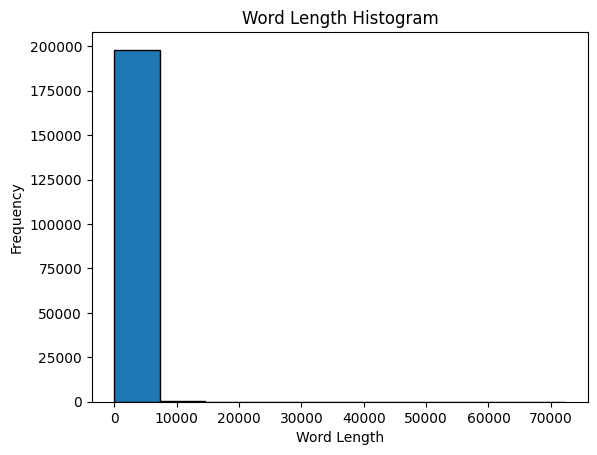

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Bin word lengths into 10 buckets
bins = pd.qcut(clean_lengths, q=10)

# Plot histogram
plt.hist(clean_lengths, bins=10, edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Histogram')
plt.show()


In [25]:
# Bin word lengths into 10 buckets
bins = pd.cut(clean_lengths, bins=10)

# Calculate the bin counts and percentages
bin_counts = bins.value_counts()
percentage = bin_counts / len(clean_lengths) * 100

# Create a DataFrame to display the results
result_table = pd.DataFrame({'Bins': bin_counts.index.astype(str),
                             'Count': bin_counts.values,
                             'Percentage': percentage.values})

# Display the table
print(result_table)

                 Bins   Count  Percentage
0   (-69.334, 7236.4]  198088   99.760279
1   (7236.4, 14469.8]     459    0.231160
2  (14469.8, 21703.2]       4    0.002014
3  (21703.2, 28936.6]       5    0.002518
4  (28936.6, 36170.0]       1    0.000504
5  (36170.0, 43403.4]       6    0.003022
6  (43403.4, 50636.8]       0    0.000000
7  (50636.8, 57870.2]       0    0.000000
8  (57870.2, 65103.6]       0    0.000000
9  (65103.6, 72337.0]       1    0.000504


In [26]:
%%time

filtered_df = df_news_final_project[df_news_final_project['clean_text'].parallel_apply(lambda x: len(x) <= 1500)]
filtered_df.shape

CPU times: user 1min 6s, sys: 28.2 s, total: 1min 34s
Wall time: 1min 42s


(166243, 8)

In [27]:
clean_lengths = [len(sentence) for sentence in filtered_df['clean_text']]

# Bin word lengths into 10 buckets
bins = pd.cut(clean_lengths, bins=10)

# Calculate the bin counts and percentages
bin_counts = bins.value_counts()
percentage = bin_counts / len(clean_lengths) * 100

# Create a DataFrame to display the results
result_table = pd.DataFrame({'Bins': bin_counts.index.astype(str),
                             'Count': bin_counts.values,
                             'Percentage': percentage.values})

# Display the table
print(result_table)

               Bins  Count  Percentage
0    (1.503, 152.7]   3057    1.838874
1    (152.7, 302.4]   4110    2.472285
2    (302.4, 452.1]  10936    6.578322
3    (452.1, 601.8]  27048   16.270159
4    (601.8, 751.5]  31877   19.174943
5    (751.5, 901.2]  26121   15.712541
6   (901.2, 1050.9]  21025   12.647149
7  (1050.9, 1200.6]  17426   10.482246
8  (1200.6, 1350.3]  13711    8.247565
9  (1350.3, 1500.0]  10932    6.575916


In [28]:
print(f'{round(filtered_df.shape[0]/df_news_final_project.shape[0]*100,2)}% of news articles have length <=1500 so truncating our text to limit at 1500 tokens')

83.72% of news articles have length <=1500 so truncating our text to limit at 1500 tokens


In [7]:
%%time
df_news_final_project['clean_text'] = df_news_final_project['clean_text'].parallel_apply(lambda x: x[:1500] if len(x) > 1500 else x)


CPU times: user 45.9 s, sys: 6.54 s, total: 52.5 s
Wall time: 51.1 s


In [8]:
%%time
df_news_final_project['clean_text_case'] = df_news_final_project['clean_text_case'].parallel_apply(lambda x: x[:1500] if len(x) > 1500 else x)


CPU times: user 52.4 s, sys: 8.25 s, total: 1min
Wall time: 59.2 s


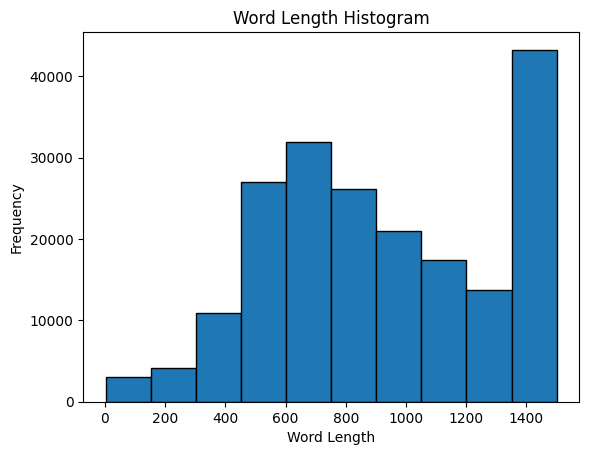

In [5]:
clean_lengths = [len(sentence) for sentence in df_news_final_project['clean_text']]

# Bin word lengths into 10 buckets
bins = pd.qcut(clean_lengths, q=10, duplicates='drop')

# Plot histogram
plt.hist(clean_lengths, bins=10, edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Histogram')
plt.show()

In [ ]:
clean_lengths = [len(sentence) for sentence in df_news_final_project['clean_text']]
print(min(sorted(clean_lengths)))
print(max(sorted(clean_lengths)))

In [9]:
%%time
from multiprocessing import Pool
import string


stop_words = stopwords.words('english')
stop_words.extend(['facebook']) 
exclude = set(string.punctuation)
wnl = nltk.WordNetLemmatizer()    

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(wnl.lemmatize(word) for word in punc_free.split())
    return normalized

def parallel_clean(data):
    with Pool() as pool:
        results = pool.map(clean, data)
    return [result.split() for result in results]


title_list = df_news_final_project['title'].tolist()
title_clean = parallel_clean(title_list)

CPU times: user 1.14 s, sys: 1.67 s, total: 2.81 s
Wall time: 7.79 s


In [10]:
title_clean_sent = [' '.join(inner_list) for inner_list in title_clean]

In [11]:
len(title_clean_sent)

198564

In [12]:
df_news_final_project['clean_title'] = title_clean_sent

In [13]:
%%time

import ktrain


tm = ktrain.text.get_topic_model(
    texts=title_clean_sent, 
    n_topics=10, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=10, 
    verbose=1)


lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
done.
CPU times: user 3min 48s, sys: 401 ms, total: 3min 48s
Wall time: 3min 51s


In [14]:
tm.print_topics()

topic 0 | data learning machine science vision computer platform leader analytics enterprise
topic 1 | news new technology time innovation chatbot video india management program
topic 2 | intelligence artificial using daily health startup online risk care robotics
topic 3 | google microsoft market ibm medical corporation bard player service covid19
topic 4 | market artificial intelligence global growth report industry analysis forecast trend
topic 5 | million raise product series voice improve gpt researcher project update
topic 6 | business world say study china cancer chief stock state firm
topic 7 | launch platform solution announces partner edge cloud powered award power
topic 8 | help tech model scientist human make newsbreak security company venturebeat
topic 9 | chatgpt tool use digital openai generative unveils post app review


In [15]:
%%time
tm.build(title_clean_sent, threshold=0.25)

done.
CPU times: user 14.1 s, sys: 44.3 ms, total: 14.2 s
Wall time: 14.2 s


In [16]:
tm.print_topics(show_counts=True)

topic:7 | count:20181 | launch platform solution announces partner edge cloud powered award power
topic:9 | count:19176 | chatgpt tool use digital openai generative unveils post app review
topic:4 | count:17453 | market artificial intelligence global growth report industry analysis forecast trend
topic:2 | count:15763 | intelligence artificial using daily health startup online risk care robotics
topic:8 | count:13433 | help tech model scientist human make newsbreak security company venturebeat
topic:6 | count:12552 | business world say study china cancer chief stock state firm
topic:0 | count:12308 | data learning machine science vision computer platform leader analytics enterprise
topic:5 | count:11854 | million raise product series voice improve gpt researcher project update
topic:1 | count:11331 | news new technology time innovation chatbot video india management program
topic:3 | count:11079 | google microsoft market ibm medical corporation bard player service covid19


In [17]:
from nltk.text import Text

# Flatten the nested list
flat_corpus = [word for inner_list in title_clean for word in inner_list]

# Create an NLTK Text object
text = Text(flat_corpus)

# Use the concordance method
text.concordance("cancer")

Displaying 25 of 2192 matches:
lop ai system detect grade prostate cancer health news et healthworld gpt heal
 multisite multitissue expansion ai cancer diagnosis across france aromyx laun
fectiveness lunit ai diagnostic aid cancer treatment well health join digital 
e ai platform aid oncologist breast cancer screening healthcare news rogue ai 
nio imaging receives ce mark detect cancer time surgery using artificial intel
like algorithm could crack language cancer alzheimer’s study find alloras carl
he ai solution early detection lung cancer 3 emerging artificial intelligence 
ghlight effectiveness ai predicting cancer treatment outcome finding presented
nical efficacy ai first time breast cancer research abstract presented rsna 20
ation – ethernet academy early lung cancer diagnosis using ai technology profe
tin ibex receives ce mark ai breast cancer solutionsmedtech innovation exbulle
para ai personalize optimize breast cancer detection state chinookobservercom 
h us ai identify earl

In [18]:
df_news_final_project.head()

,url,date,language,title,text,year_month,clean_text_case,clean_text,clean_title
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,2021-03,"[Artificial, intelligence, improves, parking, ...","[artificial, intelligence, improves, parking, ...",artificial intelligence improves parking effic...
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,2020-02,"[Children, With, Autism, Saw, Their, Learning,...","[children, with, autism, saw, their, learning,...",child autism saw learning social skill boosted...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",2021-03,"[Forget, ML, , AI, Industry, 4.0, , obsolescen...","[forget, ml, , ai, industry, 4.0, , obsolescen...",forget ml ai industry 40 – obsolescence focus ...
3,http://www.homeoffice.consumerelectronicsnet.c...,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,2021-03,"[Strategy, Analytics, , , Smartphones, Sold, G...","[strategy, analytics, , , smartphones, sold, g...",strategy analytics 71 smartphones sold globall...
4,http://www.itbusinessnet.com/2020/10/olympus-t...,2020-10-20,en,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...,2020-10,"[Olympus, Support, Endoscopic, AI, Diagnosis, ...","[olympus, support, endoscopic, ai, diagnosis, ...",olympus support endoscopic ai diagnosis educat...


In [19]:
columns_to_drop = ['language', 'url']
df_news_final_project.drop(columns=columns_to_drop, inplace=True)

In [20]:
%%time


# Define basic punctuation characters
punctuation = string.punctuation

# Function to clean a single token
def clean_token(token):
    # Remove leading/trailing spaces
    token = token.strip()
    
    # Remove stopwords
    if token.lower() in stop_words:
        return None
    
    # Remove punctuation
    token = ''.join(char for char in token if char not in punctuation)
    
    # Remove empty tokens
    if len(token) == 0:
        return None
    
    return token


# Apply cleaning to the 'tokens' column in parallel
df_news_final_project['clean_text'] = df_news_final_project['clean_text'].parallel_apply(lambda sublist: [clean_token(token) for token in sublist if clean_token(token) is not None])
df_news_final_project['clean_text_case'] = df_news_final_project['clean_text_case'].parallel_apply(lambda sublist: [clean_token(token) for token in sublist if clean_token(token) is not None])

CPU times: user 2min 21s, sys: 43.6 s, total: 3min 4s
Wall time: 6min 19s


In [21]:
df_news_final_project.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198564 entries, 0 to 200331
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             198564 non-null  datetime64[ns]
 1   title            198564 non-null  object        
 2   text             198564 non-null  object        
 3   year_month       198564 non-null  period[M]     
 4   clean_text_case  198564 non-null  object        
 5   clean_text       198564 non-null  object        
 6   clean_title      198564 non-null  object        
dtypes: datetime64[ns](1), object(5), period[M](1)
memory usage: 12.1+ MB


In [22]:
#after limiting to 1500 length
df_news_final_project.to_parquet('02_clean_df.parquet')